# CNN for CIFAR-10

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

Computer algorithms for recognizing objects in photos often learn by example. CIFAR-10 is a set of images that can be used to teach a computer how to recognize objects. Since the images in CIFAR-10 are low-resolution (32x32), this dataset can allow researchers to quickly try different algorithms to see what works. Various kinds of convolutional neural networks tend to be the best at recognizing the images in CIFAR-10.

CIFAR-10 is a labeled subset of the 80 million tiny images dataset. When the dataset was created, students were paid to label all of the images.

In [2]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url

## Download dataset from fast.ai and extract

In [3]:
dataset_url='http://files.fast.ai/data/cifar10.tgz'
download_url(dataset_url, '.')

In [4]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [5]:
data_dir='./data/cifar10'
print(os.listdir(data_dir))

['labels.txt', 'train', 'test']


In [6]:
classes=os.listdir(data_dir+'/train')
classes

['horse',
 'bird',
 'ship',
 'frog',
 'cat',
 'truck',
 'airplane',
 'automobile',
 'deer',
 'dog']

In [7]:
len_train_deer=len(os.listdir(data_dir+'/train/deer'))
print(len_train_deer)
len_test_deer=len(os.listdir(data_dir+'/test/deer'))
print(len_test_deer)

5000
1000


In [8]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

## Convert Image to Tensor

In [9]:
dataset=ImageFolder(data_dir+'/train', transform=ToTensor())

In [10]:
image, label = dataset[40000]
print(image, label)

tensor([[[0.3843, 0.3569, 0.3216,  ..., 0.4235, 0.4078, 0.4078],
         [0.7804, 0.8627, 0.8902,  ..., 0.7176, 0.6078, 0.7451],
         [0.8510, 0.8471, 0.8510,  ..., 0.6588, 0.6000, 0.6431],
         ...,
         [0.3216, 0.3255, 0.3176,  ..., 0.3020, 0.3294, 0.3333],
         [0.3059, 0.3098, 0.3412,  ..., 0.2510, 0.3137, 0.3294],
         [0.3176, 0.3255, 0.3216,  ..., 0.2863, 0.3059, 0.3216]],

        [[0.3529, 0.3255, 0.2941,  ..., 0.4000, 0.3961, 0.4039],
         [0.7333, 0.8157, 0.8431,  ..., 0.6667, 0.5647, 0.7098],
         [0.8000, 0.7922, 0.7961,  ..., 0.6235, 0.5725, 0.6235],
         ...,
         [0.4314, 0.4275, 0.3765,  ..., 0.4118, 0.4353, 0.4392],
         [0.4157, 0.4078, 0.4235,  ..., 0.3608, 0.4196, 0.4353],
         [0.4196, 0.4196, 0.4196,  ..., 0.3961, 0.4118, 0.4275]],

        [[0.3176, 0.2784, 0.2392,  ..., 0.3529, 0.3294, 0.3451],
         [0.6588, 0.7490, 0.7843,  ..., 0.6157, 0.5176, 0.6745],
         [0.7098, 0.7137, 0.7216,  ..., 0.5255, 0.4980, 0.

Label:  ship (8)


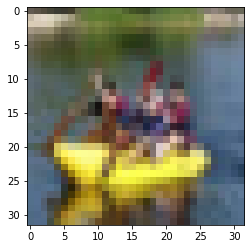

In [11]:
import matplotlib.pyplot as plt
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
show_example(*dataset[40000])

In [12]:
import numpy as np

def split_indices(n, val):
    n_val=int(n*val)
    indx=np.random.permutation(n)
    return indx[:n_val], indx[n_val:]

val_indices, train_indices=split_indices(len(dataset), 0.2)
print(len(train_indices), len(val_indices))

40000 10000


In [13]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

## Load data randomly to train set and validation set

In [14]:
batch_size=128
train_sampler=SubsetRandomSampler(train_indices)
train_dl=DataLoader(dataset, batch_size, sampler=train_sampler)
valid_sampler=SubsetRandomSampler(val_indices)
valid_dl=DataLoader(dataset, batch_size, sampler=valid_sampler)

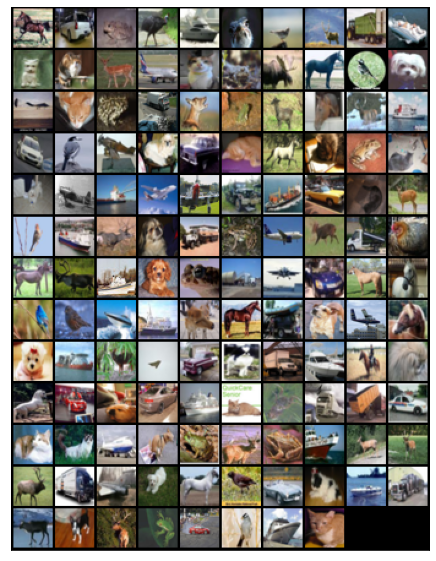

In [15]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, 10).permute(1, 2, 0))
        break
show_batch(train_dl)

In [16]:
import torch.nn as nn
import torch.nn.functional as F

## Define Model

In [17]:
model=nn.Sequential(
    nn.Conv2d(3,16,kernel_size=3, stride=1, padding =1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(16,32,kernel_size=3, stride=1, padding =1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(32,64,kernel_size=3, stride=1, padding =1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(64,128,kernel_size=3, stride=1, padding =1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(128,128,kernel_size=3, stride=1, padding =1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Flatten(),
    nn.Linear(128,10)
    )

## Get device details 

In [18]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

## Load data to device

In [19]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

## Load data one by one to avoid overloading of the GPU

In [20]:
class Device_DataLoader():
    def __init__(self, dl, device):
        self.dl=dl
        self.device=device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [21]:
device = get_default_device()
device

device(type='cuda')

In [22]:
train_dl = Device_DataLoader(train_dl, device)
valid_dl = Device_DataLoader(valid_dl, device)
to_device(model, device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten()
  (16): Linear(in_features=128, out_features=10, bias=True)
)

In [23]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    preds = model(xb)
    loss = loss_func(preds, yb)
                     
    if opt is not None:
        loss.backward()            
        opt.step()
        opt.zero_grad()
    
    metric_result = None
    if metric is not None:
        metric_result = metric(preds, yb)
    
    return loss.item(), len(xb), metric_result

In [24]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb,yb in valid_dl]
        losses, nums, metrics = zip(*results)
        total = np.sum(nums)
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total, avg_metric

In [25]:
def fit(epochs, model, loss_fn, train_dl, valid_dl, 
        opt_fn=None, lr=None, metric=None):
    train_losses, val_losses, val_metrics = [], [], []
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            train_loss,_,_ = loss_batch(model, loss_fn, xb, yb, opt)
        model.eval()
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)
        if metric is None:
            print('Epoch [{}/{}], train_loss: {:4f}, val_loss: {:.4f}'
                  .format(epoch+1, epochs, train_loss, val_loss))
        else:
            print('Epoch [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}, val_{}: {:.4f}'
                  .format(epoch+1, epochs, train_loss, val_loss, 
                          metric.__name__, val_metric))
    return train_losses, val_losses, val_metrics

In [26]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [27]:
val_loss, _, val_acc = evaluate(model, F.cross_entropy, 
                                    valid_dl, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))

Loss: 2.3037, Accuracy: 0.0976


In [28]:
num_epochs = 30
opt_fn = torch.optim.SGD
lr = 0.005

In [29]:
history = fit(num_epochs, model, F.cross_entropy, 
              train_dl, valid_dl, opt_fn, lr, accuracy)


Epoch [1/30], train_loss: 2.3172, val_loss: 2.3028, val_accuracy: 0.0976
Epoch [2/30], train_loss: 2.3051, val_loss: 2.3021, val_accuracy: 0.0976
Epoch [3/30], train_loss: 2.3039, val_loss: 2.3014, val_accuracy: 0.0977
Epoch [4/30], train_loss: 2.2946, val_loss: 2.3008, val_accuracy: 0.0977
Epoch [5/30], train_loss: 2.2997, val_loss: 2.3000, val_accuracy: 0.0980
Epoch [6/30], train_loss: 2.2979, val_loss: 2.2991, val_accuracy: 0.0981
Epoch [7/30], train_loss: 2.2915, val_loss: 2.2977, val_accuracy: 0.0981
Epoch [8/30], train_loss: 2.3038, val_loss: 2.2957, val_accuracy: 0.0984
Epoch [9/30], train_loss: 2.2893, val_loss: 2.2929, val_accuracy: 0.0995
Epoch [10/30], train_loss: 2.2894, val_loss: 2.2886, val_accuracy: 0.1036
Epoch [11/30], train_loss: 2.2796, val_loss: 2.2817, val_accuracy: 0.1105
Epoch [12/30], train_loss: 2.2734, val_loss: 2.2703, val_accuracy: 0.1331
Epoch [13/30], train_loss: 2.2607, val_loss: 2.2484, val_accuracy: 0.1557
Epoch [14/30], train_loss: 2.2062, val_loss: 2.

In [30]:
history = fit(10, model, F.cross_entropy, 
              train_dl, valid_dl, opt_fn, lr, accuracy)

Epoch [1/10], train_loss: 1.5122, val_loss: 1.7175, val_accuracy: 0.3768
Epoch [2/10], train_loss: 1.6157, val_loss: 1.6524, val_accuracy: 0.4001
Epoch [3/10], train_loss: 1.4813, val_loss: 1.6309, val_accuracy: 0.4053
Epoch [4/10], train_loss: 1.6084, val_loss: 1.6269, val_accuracy: 0.4084
Epoch [5/10], train_loss: 1.6638, val_loss: 1.6445, val_accuracy: 0.4017
Epoch [6/10], train_loss: 1.5722, val_loss: 1.6731, val_accuracy: 0.3945
Epoch [7/10], train_loss: 1.7591, val_loss: 1.6542, val_accuracy: 0.4021
Epoch [8/10], train_loss: 1.6035, val_loss: 1.5872, val_accuracy: 0.4266
Epoch [9/10], train_loss: 1.9629, val_loss: 2.0352, val_accuracy: 0.3461
Epoch [10/10], train_loss: 1.4212, val_loss: 1.5494, val_accuracy: 0.4426


In [31]:
history = fit(5, model, F.cross_entropy, 
              train_dl, valid_dl, opt_fn, lr, accuracy)

Epoch [1/5], train_loss: 1.4226, val_loss: 1.5282, val_accuracy: 0.4438
Epoch [2/5], train_loss: 1.3402, val_loss: 1.5655, val_accuracy: 0.4350
Epoch [3/5], train_loss: 1.5299, val_loss: 1.4932, val_accuracy: 0.4633
Epoch [4/5], train_loss: 1.4010, val_loss: 1.4920, val_accuracy: 0.4656
Epoch [5/5], train_loss: 1.4562, val_loss: 1.4829, val_accuracy: 0.4653


In [32]:
history = fit(5, model, F.cross_entropy, 
              train_dl, valid_dl, opt_fn, lr, accuracy)

Epoch [1/5], train_loss: 1.3825, val_loss: 1.4651, val_accuracy: 0.4729
Epoch [2/5], train_loss: 1.2612, val_loss: 1.4491, val_accuracy: 0.4842
Epoch [3/5], train_loss: 1.3803, val_loss: 1.4784, val_accuracy: 0.4680
Epoch [4/5], train_loss: 1.1949, val_loss: 1.4106, val_accuracy: 0.4897
Epoch [5/5], train_loss: 1.4111, val_loss: 1.4094, val_accuracy: 0.4961


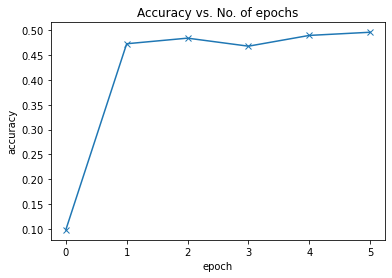

In [33]:
train_losses, val_losses, val_metrics = history
def plot_metric(metric_values):
    """Plot metric values in a line graph"""
    plt.plot(metric_values, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_metric([val_acc] + val_metrics)

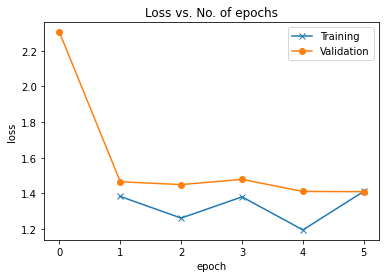

In [34]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, '-x')
    plt.plot(val_losses, '-o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses([None]+train_losses, [val_loss]+val_losses)

In [35]:
test_dataset=ImageFolder(data_dir+'/test', transform=ToTensor())

In [36]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

Label: airplane , Predicted: airplane


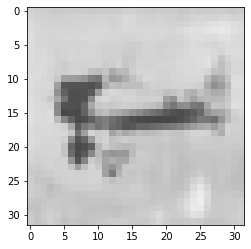

In [37]:
img, label = test_dataset[3]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [38]:
test_loader = DataLoader(test_dataset, batch_size=200)
test_dl = Device_DataLoader(test_loader, device)
test_loss, total, test_acc = evaluate(model, F.cross_entropy, test_dl, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(test_loss, test_acc))

Loss: 1.3881, Accuracy: 0.5040


In [39]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')
